In [1]:
import heeps
from heeps.util.img_processing import get_radial_profile
from heeps.util.coord import disk_coord, mas2rms
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

### We use N-band CLC at L band (backup to observe AlphaCen, in case RAP mannufacturing fails)

In [2]:
def add_curve(xy, label, rel_flux=1):
    x = xy[0]
    y = xy[1] * rel_flux
    if 'IMG' in label:
        plt.plot(x , y, 'k', label=label)
    else:
        plt.plot(x , y, label=label)
    plt.legend()
    plt.xlabel('Angular separation [mas]')
    plt.ylabel('Relative flux')
    plt.grid(True); plt.grid(which='minor', linestyle=':')
    plt.yscale('log')
    plt.xlim(0, 200)
    plt.ylim(1e-6, 1);

def rel_flux(case, band='L', mode='CLC', xbin=1, nframes_avg=100, nframes=2000, 
             clc_diam = 250.6, run_adi=False, duration='1min', verbose=False):
    conf = dict(
        dir_output = 'output_files/resolved_stars_%s/%s'%(duration, case),
        band = band,
        mode = mode,
        add_phase = False,
        f_phase = 'wavefront/cfull/cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits',
        nframes = 1,
        nframes_avg = nframes_avg,
        clc_diam = clc_diam,
    )
    if 'RAVC' in conf['mode']:
        conf.update(ls_dRext=0.0477, ls_dRint=0.04, ls_dRspi=0.0249)
    elif 'CVC' in conf['mode']:
        conf.update(ls_dRext=0.0209, ls_dRint=0.09, ls_dRspi=0.0245)
    elif 'CLC' in conf['mode']:
        conf.update(ls_dRext=0.1095, ls_dRint=0.0491, ls_dRspi=0.0317)
    conf = heeps.config.read_config(**conf)
    conf = heeps.config.update_config(**conf)
    wf = heeps.pupil.pupil(**conf)
    # image radius
    rim = conf['ndet'] // 2 
    (xo,yo) = (rim, rim)
    xval = np.arange(rim)*conf['pscale']
    # ELT (reference)
    if verbose==True:
        print('ELT (reference)')
    conf['mode'] = 'ELT'
    psf_elt = heeps.wavefront.propagate(deepcopy(wf), **conf, verbose=verbose)[0]
    yelt = get_radial_profile(psf_elt, (xo,yo), xbin)[:-1]
    peak_elt = np.max(yelt)
    yelt /= peak_elt
    os.chdir(conf['dir_output'])
    fits.writeto('psf_%s_%s_%s_no_error.fits'%(band, 'ELT', case), np.float32(psf_elt), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_no_error.fits'%(band, 'ELT', case), np.array([xval, yelt]), overwrite=True)
    # HCI; no error
    if verbose==True:
        print('HCI; no error')
    conf['mode'] = mode
    if 'alphaCen' in case:
        conf['fp_offsets'] = mas2rms(disk_coord(4.26, nr=3), 36.905)
        conf['mag'] = -1.6
    elif 'pi1Gru' in case:
        conf['fp_offsets'] = mas2rms(disk_coord(9.18, nr=4), 36.905)
        conf['mag'] = -0.6
    else:
        conf['fp_offsets'] = None
    psf = heeps.wavefront.propagate(deepcopy(wf), **conf, verbose=verbose)[0]
    yval = get_radial_profile(psf, (xo,yo), xbin)[:-1]
    yval /= peak_elt
    fits.writeto('psf_%s_%s_%s_no_error.fits'%(band, mode, case), np.float32(psf), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_no_error.fits'%(band, mode, case), np.array([xval, yval]), overwrite=True)
    # HCI; scao only
    if verbose==True:
        print('HCI; scao only')
    conf['add_phase'] = True
    conf['nframes'] = nframes
    psf_ON = heeps.wavefront.propagate(deepcopy(wf), savefits=True, verbose=verbose, **conf)
    psf_ON_avg = np.mean(psf_ON, axis=0)
    yval = get_radial_profile(psf_ON_avg, (xo,yo), xbin)[:-1]
    yval /= peak_elt
    fits.writeto('psf_%s_%s_%s_scao_only.fits'%(band, mode, case), np.float32(psf_ON_avg), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_scao_only.fits'%(band, mode, case), np.array([xval, yval]), overwrite=True)
    if run_adi is True:
        # off-axis PSF of a point-like source 
        conf['fp_offsets'] = None
        heeps.wavefront.propagate(deepcopy(wf), avg=True, onaxis=False, savefits=True, **conf);
        # adi contrast curve
        conf['add_bckg'] = False
        heeps.contrast.cc_adi(tag=case, savefits=True, verbose=True, **conf);
        if case in ['alphaCen','pi1Gru']:
            conf['add_bckg'] = True
            heeps.contrast.cc_adi(tag=case, savefits=True, **conf);

# 1/ nframes=200 -> 1 minute

In [3]:
rel_flux('pointSource', nframes=200, run_adi=False, verbose=True)

ELT (reference)
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Create on-axis PSF cube
   2024-10-17 13:58:00, e2e simulation using 56 cores
   2024-10-17 13:58:01, completed in 1.65 seconds

HCI; no error
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Create on-axis PSF cube
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.1095, 0.0491, 0.0317], ls_misalign=None
   2024-10-17 13:58:03, e2e simulation using 56 cores
   2024-10-17 13:58:07, completed in 4.09 seconds

HCI; scao only
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=200 (nframes=200, nstep=1)
Create on-axis PSF cube
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.1095, 0.0491, 0.0317], ls_misalign=None
   2024-10-17 13:58:11, e2e simulation using 56 cores
   2024-10-17 13:58:38, completed in 27.61 seconds



In [4]:
rel_flux('alphaCen', nframes=200, run_adi=False)

   2024-10-17 13:58:39, e2e simulation using 56 cores
   2024-10-17 13:58:41, completed in 1.85 seconds
   2024-10-17 13:58:43, e2e simulation using 56 cores
   2024-10-17 13:59:27, completed in 44.68 seconds
   2024-10-17 13:59:31, e2e simulation using 56 cores
   2024-10-17 14:07:22, completed in 470.53 seconds


In [5]:
rel_flux('pi1Gru', nframes=200, run_adi=False)

   2024-10-17 14:07:22, e2e simulation using 56 cores
   2024-10-17 14:07:25, completed in 2.6 seconds
   2024-10-17 14:07:26, e2e simulation using 56 cores
   2024-10-17 14:08:59, completed in 92.51 seconds
   2024-10-17 14:09:03, e2e simulation using 56 cores
   2024-10-17 14:23:15, completed in 852.18 seconds


### raw contrast

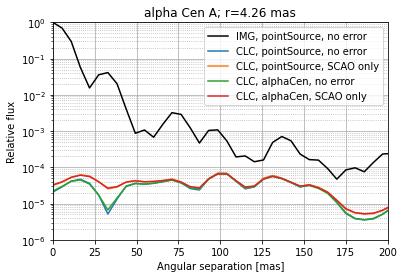

In [6]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/resolved_stars_1min')))
case = 'pointSource'
add_curve(fits.getdata('%s/rel_flux_L_ELT_%s_no_error.fits'%(case, case)), 'IMG, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
case = 'alphaCen'
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
plt.title('alpha Cen A; r=4.26 mas')
plt.savefig('rel_flux_%s.png'%case, dpi=300, transparent=True)

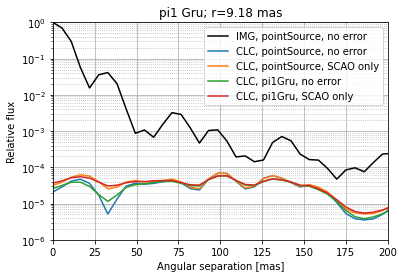

In [7]:
case = 'pointSource'
add_curve(fits.getdata('%s/rel_flux_L_ELT_%s_no_error.fits'%(case, case)), 'IMG, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
case = 'pi1Gru'
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
plt.title('pi1 Gru; r=9.18 mas')
plt.savefig('rel_flux_%s.png'%case, dpi=300, transparent=True)

# 2/ nframes=2000 -> 10 minutes

In [8]:
rel_flux('pointSource', nframes=2000, run_adi=True, duration='10min', mode='ELT')
rel_flux('pointSource', nframes=2000, run_adi=True, duration='10min', mode='RAVC')
rel_flux('pointSource', nframes=2000, run_adi=True, duration='10min', mode='CLC')

   2024-10-17 14:23:19, e2e simulation using 56 cores
   2024-10-17 14:23:21, completed in 2.59 seconds
   2024-10-17 14:23:23, e2e simulation using 56 cores
   2024-10-17 14:23:27, completed in 4.27 seconds
   2024-10-17 14:23:41, e2e simulation using 56 cores
   2024-10-17 14:27:39, completed in 237.71 seconds
   2024-10-17 14:27:53, e2e simulation using 56 cores
   2024-10-17 14:28:09, completed in 16.22 seconds
Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=CLC, band=L, pscale=5.47 mas
   ncube=2000, ndet=403, duration=3600 s
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-17 14:28:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.8543229759036524, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:17:15.607457
―――

In [9]:
rel_flux('alphaCen', nframes=2000, run_adi=True, duration='10min', mode='ELT')
rel_flux('alphaCen', nframes=2000, run_adi=True, duration='10min', mode='RAVC')
rel_flux('alphaCen', nframes=2000, run_adi=True, duration='10min', mode='CLC')

In [10]:
rel_flux('pi1Gru', nframes=2000, run_adi=True, duration='10min', mode='ELT')
rel_flux('pi1Gru', nframes=2000, run_adi=True, duration='10min', mode='RAVC')
rel_flux('pi1Gru', nframes=2000, run_adi=True, duration='10min', mode='CLC')

### figures

In [11]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/resolved_stars_1min')))
case = 'pointSource'
add_curve(fits.getdata('%s/rel_flux_L_ELT_%s_no_error.fits'%(case, case)), 'IMG, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
case = 'alphaCen'
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_no_error.fits'%(case, case)), 'CLC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_CLC_%s_scao_only.fits'%(case, case)), 'CLC, %s, SCAO only'%case)
plt.title('alpha Cen A; r=4.26 mas')
plt.savefig('rel_flux_%s.png'%case, dpi=300, transparent=True)

   2024-10-17 14:45:41, e2e simulation using 56 cores
   2024-10-17 14:45:48, completed in 6.65 seconds
   2024-10-17 14:45:48, e2e simulation using 56 cores
   2024-10-17 14:45:55, completed in 6.56 seconds
   2024-10-17 14:46:11, e2e simulation using 56 cores
   2024-10-17 14:47:38, completed in 87.15 seconds
   2024-10-17 14:47:55, e2e simulation using 56 cores
   2024-10-17 14:48:12, completed in 16.95 seconds
Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=ELT, band=L, pscale=5.47 mas
   ncube=2000, ndet=403, duration=3600 s
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-17 14:48:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.518070609148814, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:18:34.846913
―――――

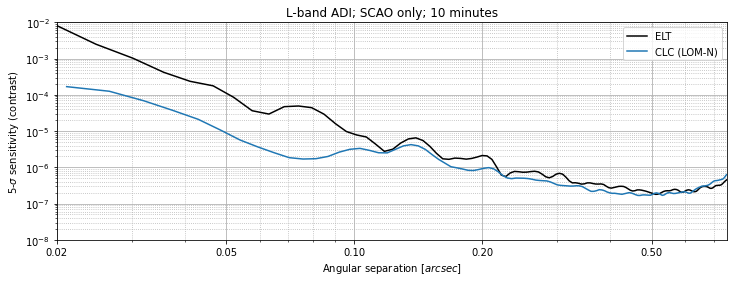

In [13]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/resolved_stars_10min')))
xlabel = 'Angular separation $[arcsec]$'
ylabel_adi = '5-$\sigma$ sensitivity (contrast)'
plt.figure(figsize=(12,4))
case = 'pointSource'
SO_L_PS1 = fits.getdata('%s/cc_adi_bckg0_L_ELT_%s.fits'%(case, case))
plt.plot(SO_L_PS1[0], SO_L_PS1[1], 'k', label='ELT')
SO_L_PS = fits.getdata('%s/cc_adi_bckg0_L_CLC_%s.fits'%(case, case))
plt.plot(SO_L_PS[0], SO_L_PS[1], label='CLC (LOM-N)')
#case = 'alphaCen'
#SO_L_AC = fits.getdata('%s/cc_adi_bckg0_L_CLC_%s.fits'%(case, case))
#plt.plot(SO_L_AC[0], SO_L_AC[1], label='alpha Cen A')
#case = 'pi1Gru'
#SO_L_PG = fits.getdata('%s/cc_adi_bckg0_L_CLC_%s.fits'%(case, case))
#plt.plot(SO_L_PG[0], SO_L_PG[1], label='pi1 Gru')
plt.loglog()
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel_adi)
plt.title('L-band ADI; SCAO only; 10 minutes')
plt.xlim(0.02, 0.75)
plt.ylim(1e-8, 1e-2)
plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('resolved_stars_10min.png', transparent=True, dpi=300)